# Multiple - Hyperspectral image analysis and classification

In [35]:
%%capture
!python -m pip install -U abraia
!python -m pip install wget

import os
if not os.getenv('ABRAIA_KEY'):
    #@markdown <a href="https://abraia.me/console/settings" target="_blank">Get your ABRAIA_KEY</a>
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_KEY=$abraia_key

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abraia import Multiple, hsi

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

multiple = Multiple()

## Download and read the HSI data

As an example, we'll use the Indian Pines (IP) Hyperspectral Image Dataset. It was gathered using the AVIRIS sensor over the Indian Pines test site in North-western Indiana and it consists of and image of 145 X 145 pixels and 200 spectral bands, with 16 labels over the image.

In [36]:
hsiImg, gt, class_names = hsi.load_dataset('IP')

print(f'HSI image size (width, height, bands): {hsiImg.shape}')
summary = pd.DataFrame([{'class_name': label, 'samples': np.sum(gt == val)} for val, label in enumerate(class_names)])
summary.iloc[1:]

HSI image size (width, height, bands): (145, 145, 200)


,class_name,samples
1,Alfalfa,46
2,Corn-notill,1428
3,Corn-mintill,830
4,Corn,237
5,Grass-pasture,483
6,Grass-trees,730
7,Grass-pasture-mowed,28
8,Hay-windrowed,478
9,Oats,20
10,Soybean-notill,972


## Visualize bands and ground truth

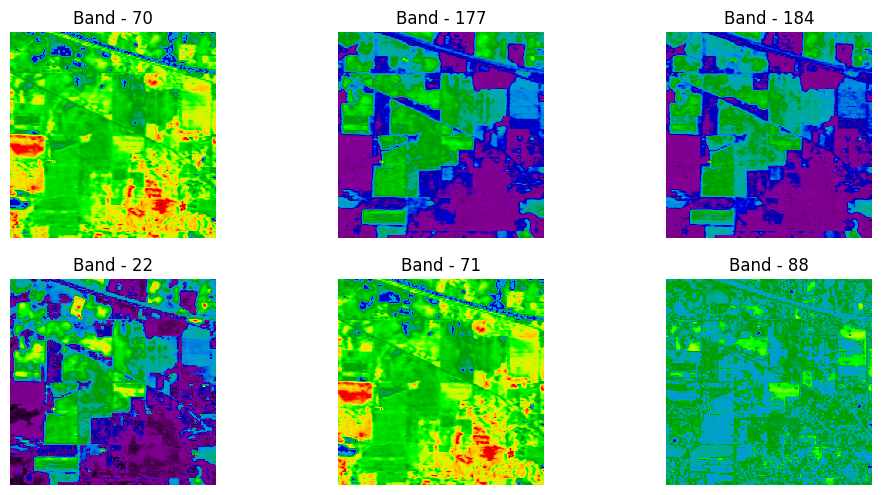

In [37]:
# Some random bands
imgs, indexes = hsi.random(hsiImg)

ax = plt.subplots(2, 3)[1].reshape(-1)
for i, img in enumerate(imgs):
    ax[i].title.set_text(f'Band - {indexes[i]}')
    ax[i].imshow(img, cmap='nipy_spectral')
    ax[i].axis('off')

(-0.5, 144.5, 144.5, -0.5)

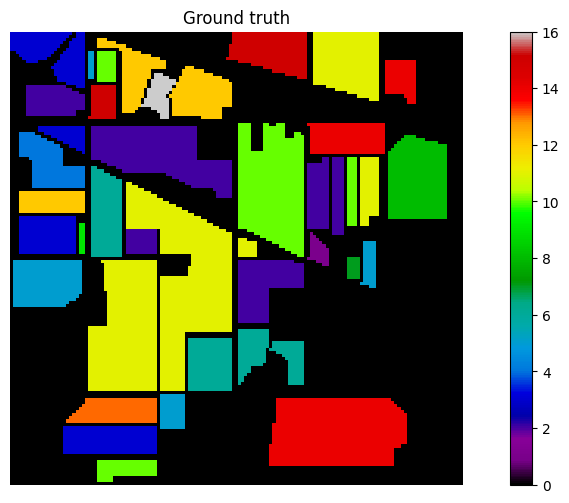

In [38]:
plt.title('Ground truth')
plt.imshow(gt, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

## Dimensionality reduction (PCA) and visualization

First, we analyze the redundancy in the data available using PCA decomposition.

Text(0, 0.5, 'Cumulative explained variance')

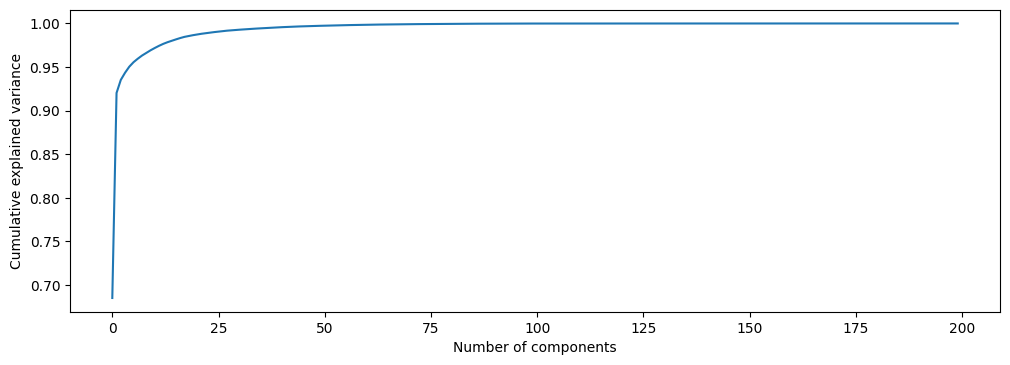

In [39]:
from sklearn.decomposition import PCA

# Transform image to array of samples (with corresponding spectra) and ground truth to array of labels 
X, y = hsiImg, gt
r, c, d = X.shape
X = X.reshape((r * c), d)
y = y.reshape((r * c))

pca = PCA()
pcX = pca.fit_transform(X)
ev=pca.explained_variance_ratio_

fig = plt.figure(figsize=(12, 4))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

The curve shows that practically all variance is explained with the first 50 principal components. The rest of them are likely to contain mostly noise.

We can also visualize the first principal components of the spectral bands. As we see, components with lower variance values appear more and more noisy.

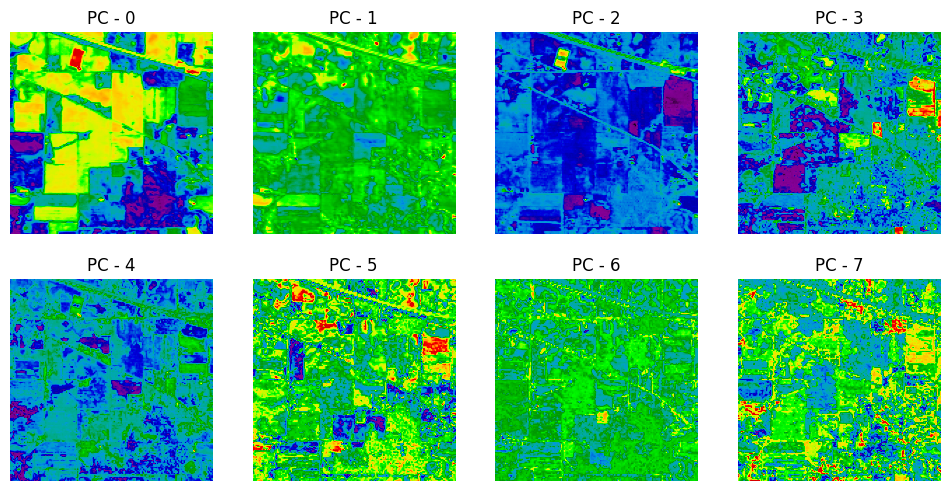

In [40]:
X = hsi.principal_components(hsiImg, n_components=40)

ax = plt.subplots(2, 4)[1].reshape(-1)
for i in range(8):
    ax[i].title.set_text(f'PC - {i}')
    ax[i].imshow(X[:,:,i], cmap='nipy_spectral')
    ax[i].axis('off')

# SVM training

We may simplify the job to the SVM model by reducing redundancy and decorrelation across spectral bands. We use the reduced bands result of the PCA to feed the classifier, removing noise and irrelevant information that won't improve the performance of our clasifier. But even if we don't want to apply a reduction of the number of components, decorrelating the bands before feeding the classifier is a good practice with classic classfifiers like support vector machines. With the IP dataset, it improves performace by a 10%.

In [41]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def create_model(kernel='rbf'):
    return SVC(C=150, kernel=kernel)

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    return model.predict(X_test)

def predict_model(model, X_pred):
    return model.predict(X).reshape(r, c)

# Preparing data for training and testing
r, c, d = X.shape
X = X.reshape((r * c), d)
X_train, X_test, y_train, y_test = hsi.split_train_test(X, y)

model = create_model()
train_model(model, X_train, y_train)
y_pred = evaluate_model(model, X_test, y_test)

print('Overall accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=class_names))
print(confusion_matrix(y_test, y_pred))

                              precision    recall  f1-score   support

                                   0.79      0.84      0.82      3233
                     Alfalfa       1.00      0.79      0.88        14
                 Corn-notill       0.68      0.67      0.68       428
                Corn-mintill       0.76      0.65      0.70       249
                        Corn       0.48      0.52      0.50        71
               Grass-pasture       0.83      0.72      0.77       145
                 Grass-trees       0.80      0.75      0.77       219
         Grass-pasture-mowed       0.83      0.62      0.71         8
               Hay-windrowed       0.86      0.89      0.87       143
                        Oats       0.60      0.50      0.55         6
              Soybean-notill       0.71      0.67      0.69       292
             Soybean-mintill       0.76      0.74      0.75       737
               Soybean-clean       0.72      0.62      0.66       178
                   

## Classification result

In [42]:
clmap = predict_model(model, X)

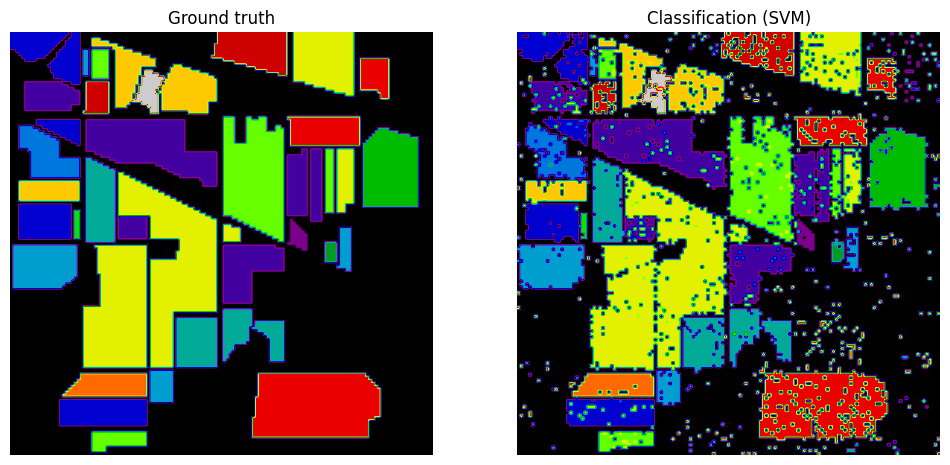

In [43]:
plt.subplot(121)
plt.title('Ground truth')
plt.imshow(gt, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(122)
plt.title('Classification (SVM)')
plt.imshow(clmap, cmap='nipy_spectral')
plt.axis('off')
plt.show()